<a href="https://colab.research.google.com/github/Edsondev21/Projet_7/blob/main/P7_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/d1_nettoyé.csv')

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Age,Annee_travail,Percent_credit_revenu,Percent_loyer_revenu,Duree
0,100002,1,Cash loans,M,202500.0,406597.5,24700.5,351000.0,1.0,0.083037,0.262949,0.139376,25.920548,1.0,2.007889,0.121978,0.060749
1,100003,0,Cash loans,F,270000.0,1293502.5,35698.5,1129500.0,2.0,0.311267,0.622246,NaN,45.931507,3.0,4.790750,0.132217,0.027598
2,100004,0,Revolving loans,M,67500.0,135000.0,6750.0,135000.0,1.0,NaN,0.555912,0.729567,52.180822,0.0,2.000000,0.100000,0.050000
3,100006,0,Cash loans,F,135000.0,312682.5,29686.5,297000.0,2.0,NaN,0.650442,NaN,52.068493,8.0,2.316167,0.219900,0.094941
4,100007,0,Cash loans,M,121500.0,513000.0,21865.5,513000.0,1.0,NaN,0.322738,NaN,54.608219,8.0,4.222222,0.179963,0.042623


# 1) Preprocessing

## 1.1) Imputer les valeurs manquantes

In [3]:
df.fillna(df.median(), inplace = True)

## 1.2) Encodage des valeurs categorielles

Les features de type object ne sont pas ordinal nous allons donc utiliser le OnHotEncoder

In [4]:
df = pd.get_dummies(df)

## 1.3) Standardisation des données

In [5]:
# Choisir les features
X = df.iloc[:,2:]

# Et le target:
Y = df.iloc[:,1:2] 

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

## 1.4) Rééchantillonage des données

Nous allons faire une combinaison de sur-échantillonnage et de sous-échantillonnage, en utilisant les techniques de liens SMOTE et Tomek

SMOTE (Synthetic Minority Oversampling TEchnique) consiste à synthétiser des éléments pour la classe minoritaire, à partir de ceux qui existent déjà. Cela fonctionne en sélectionnant aléatoirement un point de la classe minoritaire et en calculant les k plus proches voisins pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins

Tomek permet la suppression des instances de la classe majoritaire de chaque paire. Ceci augmente l'espace entre les deux classes, facilitant le processus de classification

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 246008 lignes,
Test: 61503 lignes.



In [8]:
from imblearn.combine import SMOTETomek

smott = SMOTETomek(n_jobs=-1, random_state=0)
X_trains, Y_trains = smott.fit_resample(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


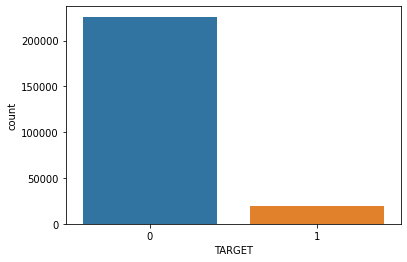

In [11]:
import seaborn as sns

sns.countplot(Y_train['TARGET'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


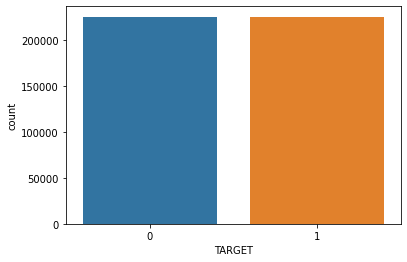

In [10]:
import seaborn as sns

sns.countplot(Y_trains['TARGET'])

In [15]:
# Enregistrer Y_trains
Y_trains.set_index("TARGET").to_csv("Y_trains.csv")

In [23]:
# Enregistrer X_trains
np.save('test3X_trains.npy', X_trains)

In [21]:
a = np.load('X_trains.npy')

# 2) Modélisation: RandomForestClassifier

##) 2.1) Choisir les meilleurs hyperparamètres

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 'n_estimators': [200, 300],
              'max_features' : [0.90, 0.99],
              'max_depth' : [20, 30]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3)
grid.fit(X_trains, Y_trains)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [35]:
print(grid.best_score_)

grid.best_params_

0.9015170299631766


{'max_depth': 20, 'n_estimators': 200}

In [26]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(max_depth = 25, max_features = 0.95, n_estimators= 160 )

rfc.fit(X_trains, Y_trains)

predicti = rfc.predict(X_test)

print(rfc.score(X_test, Y_test))
mean_squared_error(Y_test, predicti)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9020698177324683


NameError: ignored

In [27]:
print(rfc.score(X_test, Y_test))

0.9020698177324683


In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(Y_test, predicti)

0.9020698177324683

In [29]:
confusion_matrix(Y_test, predicti)

array([[55001,  1553],
       [ 4470,   479]])

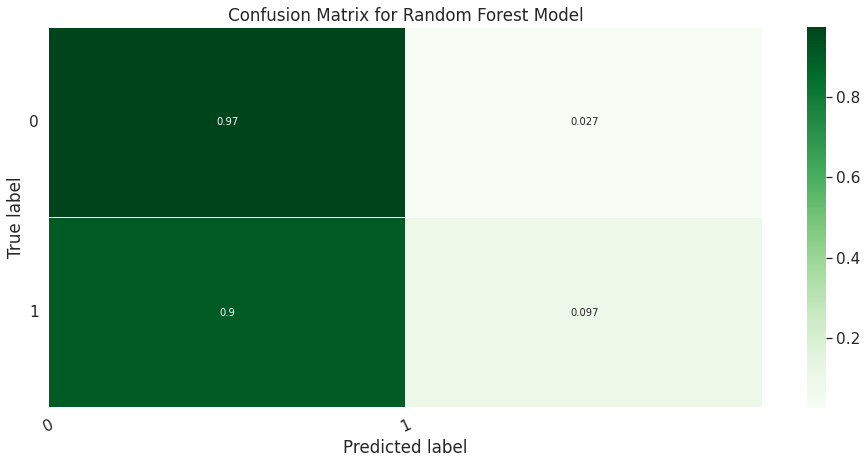

In [32]:
import matplotlib.pyplot as plt


# Get and reshape confusion matrix data
matrix = confusion_matrix(Y_test, predicti)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['0', '1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()